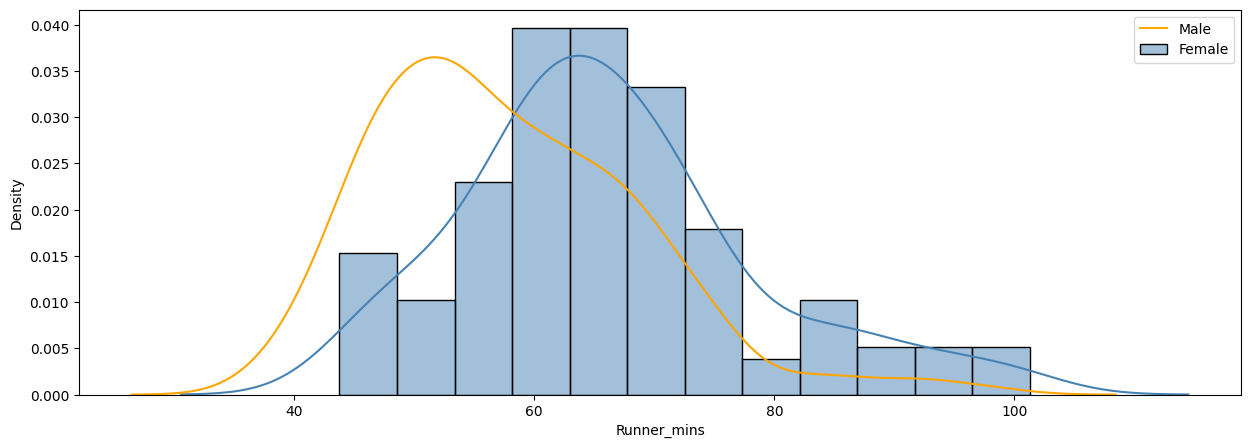

        Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
F             163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
M             414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
F        72.058333  101.300000  
M        64.804167   98.516667  


Text(0.5, 0.98, '')

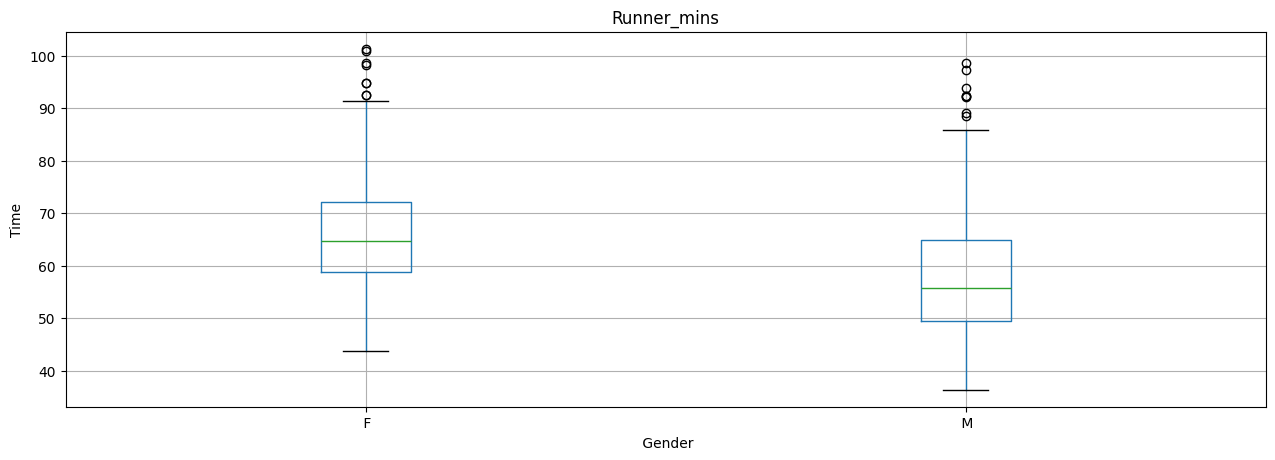

In [ ]:
import pandas as pd # Extracts, manipulates, and cleans data
import numpy as np
import matplotlib.pyplot as plt # Visualizes data
import seaborn as sns
import re
%matplotlib inline

from urllib.request import urlopen # Opens URLs
from bs4 import BeautifulSoup # Extracts data from html files
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5 # Graph size

url = "http://www.hubertiming.com/results/2017GPTR10K"
html = urlopen(url) # Gets the html of the page

# Creates a Beautiful Soup object from the html, lxml is the html parser
soup = BeautifulSoup(html, 'lxml')
type(soup)

#Prints the title
title = soup.title
# print(title)

#Gets the text of the page
text = soup.get_text()
#print(soup.text)

# soup.find_all('a') # All hyper links
# soup.find_all('table') # All tables
# soup.find_all('tr') # Table rows
# soup.find_all('th') # Table Headers-isvalid?
# soup.find_all('td') # table cells-isvalid?

#Print out only the hyper links
all_links = soup.find_all("a")
# for link in all_links:
#   print(link.get("href"))

# Print table rows only (first 10)
rows = soup.find_all('tr')
# print(rows[:10])

# Iterates through table rows and prints each cells of the rows
for row  in rows:
  row_td = row.find_all('td')
# print(row_td)
type(row_td)

# The loop above prints with tags, this will print without tags, which is usually what you want
str_cells = str(row_td)
cleantext = BeautifulSoup(str_cells, "lxml").get_text()
# print(cleantext)

#Below removes the tags using regular expressions
list_rows = []
for row in rows:
  cells = row.find_all('td')
  str_cells = str(cells)
  clean = re.compile('<.*?>') # Match anything that is <...> | ? means match non-greedy, that way shortest possible sub string
  clean2 = (re.sub(clean, '', str_cells)) # Finds all substring where regex maches and replace with empty string.
  list_rows.append(clean2)
# print(clean2)
type(clean2)

# Convert the list into pandas data frame to get quick view of first 10 rows.
  # Pandas is like having a database server within python environment.
df = pd.DataFrame(list_rows)
#df.head(10) # Will print a table

#Cleans up the data by splitting "0 column" at the comma position, and uses str.split
df1 = df[0].str.split(',', expand=True)
#df1.head(10)

# Removes open square bracket on column 0
df1[0] = df1[0].str.strip('[')
#df1.head(10)

# Table is missing headers, so find and add.
col_labels = soup.find_all('th') # Find the headers
all_header = []
col_str = str(col_labels) # Get the headers as a string
cleantext2 = BeautifulSoup(col_str, "lxml").get_text() # Get the headers as clean text.
all_header.append(cleantext2)
# print(all_header) # Shows all table headers

# Convert headers into new pandas data frame
df2 = pd.DataFrame(all_header)
df2.head()

# Split column '0' into multiple columns at the comma postion
df3 = df2[0].str.split(',', expand=True)
#df3.head() # Shows the headers.

# Use the concat method to bring the two dataframes together
frames = [df3, df1]
df4 = pd.concat(frames)
#df4.head(10)

#Re-configure the data frame so the first row is the table header
df5 = df4.rename(columns=df4.iloc[0])
#df5.head()

# Prints information about df5, such as entries and columns
# df5.info()
# df5.shape

# Gets rid of Null columns so data is validated. Normally would want to do this thoroughly
df6 = df5.dropna(axis=0, how='any')
# df6.info()
# df6.shape

#Drop the redundant header row
df7 = df6.drop(df6.index[0])
#df7.head()

# Clean up the Place and Team headers to remove the [ and ]
df7.rename(columns={'[Place' : 'Place'}, inplace=True)
df7.rename(columns={' Team]' : 'Team' }, inplace=True)
#df7.head()

# Remove the closing bracket in the cells in the Team column
#df7['Team'] = df7['Team'].str.strip(']')
#df7.head()

#FINDING AVERAGE IN MINUTES
#Time is given in mm:ss, so we need to transform to just minutes
time_list = df7[' Time'].tolist()
time_mins = []
#Loop to find each time in minutes
for time_str in time_list:
  parts = time_str.strip().split(':') #Split by colon and rm whitespace
  #If just mins:secs
  if len(parts) == 2:
    m, s = map(int, parts)
    total_mins = m + s / 60
  #If hr:min:sec
  elif len(parts) == 3:
    h, m, s = map(int, parts)
    total_mins = h * 60 + m + s / 60
  else:
    continue #Skip if bad
  time_mins.append(total_mins)

#print(time_mins)

#Add column to have the runner time in mins
df7['Runner_mins'] = time_mins
#df7.head()

#Pandas describe method computes statistics.
df7.describe(include=[np.number])

#Generate a box plot
# df7.boxplot(column='Runner_mins') #What column
# plt.grid(True, axis='y') #
# plt.ylabel('Time') # Y axis label
# plt.xticks([1], ['Runners']) #X axis ticks and label


# DID THE RUNNERS FINISH TIMES FOLLOW A NORMAL DISTRIBUTION
# Will use seaborn python plotting library
# x = df7['Runner_mins']
# ax = sns.histplot(x, bins=25, kde=True, color = 'm', edgecolor='black')#Got a warning about using distplot and didn't look right, histplot
# #ax = sns.distplot(x, hist=True, kde=True, rug=False, color='m', bins=25, hist_kws={'edgecolor':'black'})
# plt.show()


#WERE THERE ANY PERFORMANCE DIFFERENCES BETWEEN MALES AND FEMALES OF VARIOUS AGE GROUPS
f_fuko = df7.loc[df7[' Gender'] ==' F']['Runner_mins']
m_fuko = df7.loc[df7[' Gender'] ==' M']['Runner_mins']
sns.histplot(
    f_fuko,
    bins=12,
    color='steelblue',
    edgecolor='black',
    label='Female',
    stat='density',
    alpha=0.5
)

# Female KDE(Kernel Desnity Estimation) smoth curve
sns.kdeplot(
    f_fuko,
    color='steelblue',
    label='_nolegend_',
)

# Male KDE
sns.kdeplot(
    m_fuko,
    color='orange',
    label='Male',
)
plt.legend()
plt.show()

# Can get statistics if prefer using groupby()
g_stats = df7.groupby(" Gender", as_index=True).describe()
print(g_stats)

#Display a side-by-side boxplot comparison of male and female finish times
df7.boxplot(column='Runner_mins', by=' Gender')
plt.ylabel('Time')
plt.suptitle("")



